# Behavior Diffusion Modelling: Understanding Ownership Diffusion in Fantasy Sports using Neural Networks’ Prediction

Fantasy sports represent an emerging entertainment opportunity that better involves the fans in the respective sports. Through the aspect of the purchase and sale of players in the fantasy leagues, the behavior diffusion in virtual entertainment can be studied and predicted. In this project, the diffusion of the ownership of players in the Fantasy Premier League (FPL), will be explored with predictability evaluated through social influence (in terms of respective club popularity), market movements (in terms of player pricings in the fantasy leagues), player performance (in terms of player performance metrics) and game metrics (in terms of game difficulty and team strength).

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Network Modelling

In [47]:
# Packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler


## Data Importation and Data Preparation

In [6]:
# Importing FPL Data
file_path = "/content/drive/My Drive/Colab Notebooks/fpl_hist_fanbase_merged.csv"
df = pd.read_csv(file_path)
df.head()

,id_x,status,chance_of_playing_next_round,chance_of_playing_this_round,now_cost,now_cost_rank,now_cost_rank_type,cost_change_event,cost_change_event_fall,cost_change_start,...,expected_goal_involvements_momentum,team_points_avg,team_form_3,fanbase_x_points,fanbase_x_ownership,fanbase_x_transfer_pressure,influence_score,ownership_next,diffusion_target,diffusion_class
0,1,d,75.0,75.0,5.5,147,91,0,0,0,...,NaN,2.960000,NaN,0.0,0.04768,0.404528,0.050969,0.1,0.0,1
1,1,a,100.0,75.0,5.4,169,104,-1,1,-1,...,NaN,5.800000,NaN,0.0,0.04768,1.282883,0.050969,0.1,0.0,1
2,1,u,0.0,0.0,5.4,169,106,0,0,-1,...,0.0,6.178571,4.979524,0.0,0.04768,0.996369,0.050969,0.1,0.0,1
3,1,u,0.0,0.0,5.4,158,96,0,0,-1,...,0.0,7.866667,6.615079,0.0,0.04768,0.895319,0.050969,0.1,0.0,1
4,1,u,0.0,0.0,5.4,150,90,0,0,-1,...,0.0,9.066667,7.703968,0.0,0.04768,0.845195,0.050969,0.1,0.0,1


In [7]:
df.columns.tolist()

['id_x',
 'status',
 'chance_of_playing_next_round',
 'chance_of_playing_this_round',
 'now_cost',
 'now_cost_rank',
 'now_cost_rank_type',
 'cost_change_event',
 'cost_change_event_fall',
 'cost_change_start',
 'cost_change_start_fall',
 'selected_by_percent',
 'selected_rank',
 'selected_rank_type',
 'total_points',
 'event_points',
 'points_per_game',
 'points_per_game_rank',
 'points_per_game_rank_type',
 'bonus',
 'bps',
 'form',
 'form_rank',
 'form_rank_type',
 'value_form',
 'value_season',
 'dreamteam_count',
 'transfers_in',
 'transfers_in_event',
 'transfers_out',
 'transfers_out_event',
 'ep_next',
 'ep_this',
 'expected_goals',
 'expected_assists',
 'expected_goal_involvements',
 'expected_goals_conceded',
 'expected_goals_per_90',
 'expected_assists_per_90',
 'expected_goal_involvements_per_90',
 'expected_goals_conceded_per_90',
 'influence',
 'influence_rank',
 'influence_rank_type',
 'creativity',
 'creativity_rank',
 'creativity_rank_type',
 'threat',
 'threat_rank',


In [12]:
# Importing Community Data
file_path_1 = "/content/drive/My Drive/Colab Notebooks/fpl_Network_Communities.csv"
df_1 = pd.read_csv(file_path_1)
df_1.head()

,player_id,community,size
0,1,0,1
1,2,1,93
2,3,1,93
3,4,1,93
4,5,2,1


In [13]:
# Renaming Columns
df_1 = df_1.rename(columns={"size": "cluster_size"})

In [14]:
# Merging FPL Data and Community Data
df_merged = df.merge(
    df_1,
    left_on="player_id",
    right_on="player_id",
    how="left"
)
df_merged.columns.tolist()

['id_x',
 'status',
 'chance_of_playing_next_round',
 'chance_of_playing_this_round',
 'now_cost',
 'now_cost_rank',
 'now_cost_rank_type',
 'cost_change_event',
 'cost_change_event_fall',
 'cost_change_start',
 'cost_change_start_fall',
 'selected_by_percent',
 'selected_rank',
 'selected_rank_type',
 'total_points',
 'event_points',
 'points_per_game',
 'points_per_game_rank',
 'points_per_game_rank_type',
 'bonus',
 'bps',
 'form',
 'form_rank',
 'form_rank_type',
 'value_form',
 'value_season',
 'dreamteam_count',
 'transfers_in',
 'transfers_in_event',
 'transfers_out',
 'transfers_out_event',
 'ep_next',
 'ep_this',
 'expected_goals',
 'expected_assists',
 'expected_goal_involvements',
 'expected_goals_conceded',
 'expected_goals_per_90',
 'expected_assists_per_90',
 'expected_goal_involvements_per_90',
 'expected_goals_conceded_per_90',
 'influence',
 'influence_rank',
 'influence_rank_type',
 'creativity',
 'creativity_rank',
 'creativity_rank_type',
 'threat',
 'threat_rank',


In [17]:
# Sorting Data and Filling Missing Entries
df_merged = df_merged.sort_values(["player_id", "gw"]).reset_index(drop=True)
df_merged = df_merged.groupby("player_id").apply(lambda x: x.ffill().bfill()).reset_index(drop=True)

/tmp/ipython-input-1877620184.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged = df_merged.groupby("player_id").apply(lambda x: x.ffill().bfill()).reset_index(drop=True)
/tmp/ipython-input-1877620184.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merged = df_merged.groupby("player_id").apply(lambda x: x.ffill().bfill()).reset_index(drop=True)


In [18]:
# Specifying features and target
feature_cols = [
    "ownership", "fanbase_growth_weighted", "boom_flag", "bust_flag",
    "transfer_net", "transfer_pressure", "total_points_momentum", "expected_goals_momentum",
    "expected_goal_involvements_momentum", "community", "cluster_size", 'team_points_avg',
    'team_form_3','fanbase_x_points', 'fanbase_x_ownership', 'fanbase_x_transfer_pressure',
    'influence_score', 'community','cluster_size'
]

target_col = "diffusion_target"

In [19]:
# Building Length Sequence Function
seq_len = 5

def build_sequences(df, seq_len=5):
    X, y = [], []
    for pid, pdata in df.groupby("player_id"):
        pdata = pdata.sort_values("gw")
        values = pdata[feature_cols].values
        targets = pdata[target_col].values

        for i in range(len(pdata)-seq_len):
            X.append(values[i:i+seq_len])
            y.append(targets[i+seq_len])
    return np.array(X), np.array(y)

X, y = build_sequences(df_merged, seq_len)

In [49]:
# Data Partitioning
n = len(X)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(16555, 5, 19) (16555,)
(3547, 5, 19) (3547,)
(3548, 5, 19) (3548,)


In [50]:
# Scaling Target Variable
y_scaler = RobustScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1,1)).flatten()
y_val = y_scaler.transform(y_val.reshape(-1,1)).flatten()
y_test = y_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

## Modelling Initialization and Evaluation Plot

### Initialization

In [51]:
# Initializing Function
def train_with_history(model, X_train, y_train, X_val, y_val, batch_size = 10, epochs=10):

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_val_t   = torch.tensor(X_val, dtype=torch.float32)
    y_val_t   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    history = {"train": [], "val": []}

    for e in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_t)
        loss = loss_fn(pred, y_train_t)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = loss_fn(model(X_val_t), y_val_t)

        history["train"].append(loss.item())
        history["val"].append(val_loss.item())

        print(f"Epoch {e+1}/{epochs}: train={loss.item():.4f}, val={val_loss.item():.4f}")

    return history


In [52]:
input_dim = len(feature_cols)

### Training and Validation Evaluation Curve Function

In [25]:
def plot_training(history, title):
    plt.figure(figsize=(12,12))
    plt.plot(history["train"], label="Train Loss")
    plt.plot(history["val"], label="Validation Loss")
    plt.title(f"{title} - Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

### Predictions Plot

In [26]:
def plot_predictions(model, X_test, y_test, title):

    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        pred = model(X_test_t).numpy().flatten()

    actual = y_test.flatten()
    residuals = actual - pred

    # Scatterplot for actual vs predicted
    plt.figure(figsize=(12,12))
    plt.scatter(actual, pred, alpha=0.4)
    plt.xlabel("Actual Diffusion")
    plt.ylabel("Predicted Diffusion")
    plt.title(f"{title} - Predicted vs Actual")
    plt.grid(True)
    plt.show()

    # Residual distribution histogram
    plt.figure(figsize=(12,12))
    plt.hist(residuals, bins=40, alpha=0.7)
    plt.title(f"{title} - Residual Distribution")
    plt.xlabel("Residual (actual - predicted)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

## Long Short-Term Memory (LSTM) Neural Network Regression

In [28]:
# Initializing LSTM
class DiffusionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

Epoch 1/10: train=0.4955, val=0.2441
Epoch 2/10: train=0.4922, val=0.2459
Epoch 3/10: train=0.4927, val=0.2467
Epoch 4/10: train=0.4930, val=0.2462
Epoch 5/10: train=0.4925, val=0.2452
Epoch 6/10: train=0.4918, val=0.2440
Epoch 7/10: train=0.4912, val=0.2439
Epoch 8/10: train=0.4915, val=0.2437
Epoch 9/10: train=0.4913, val=0.2439
Epoch 10/10: train=0.4916, val=0.2438


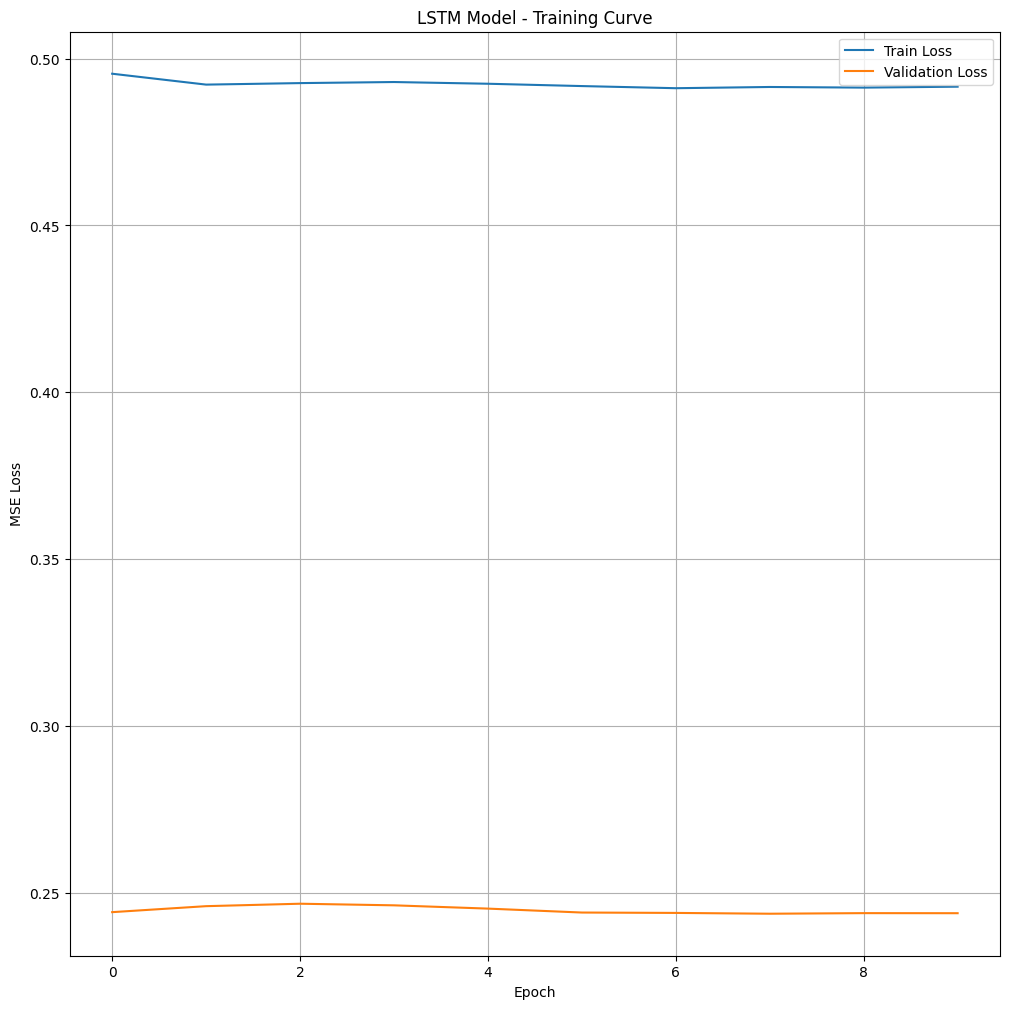

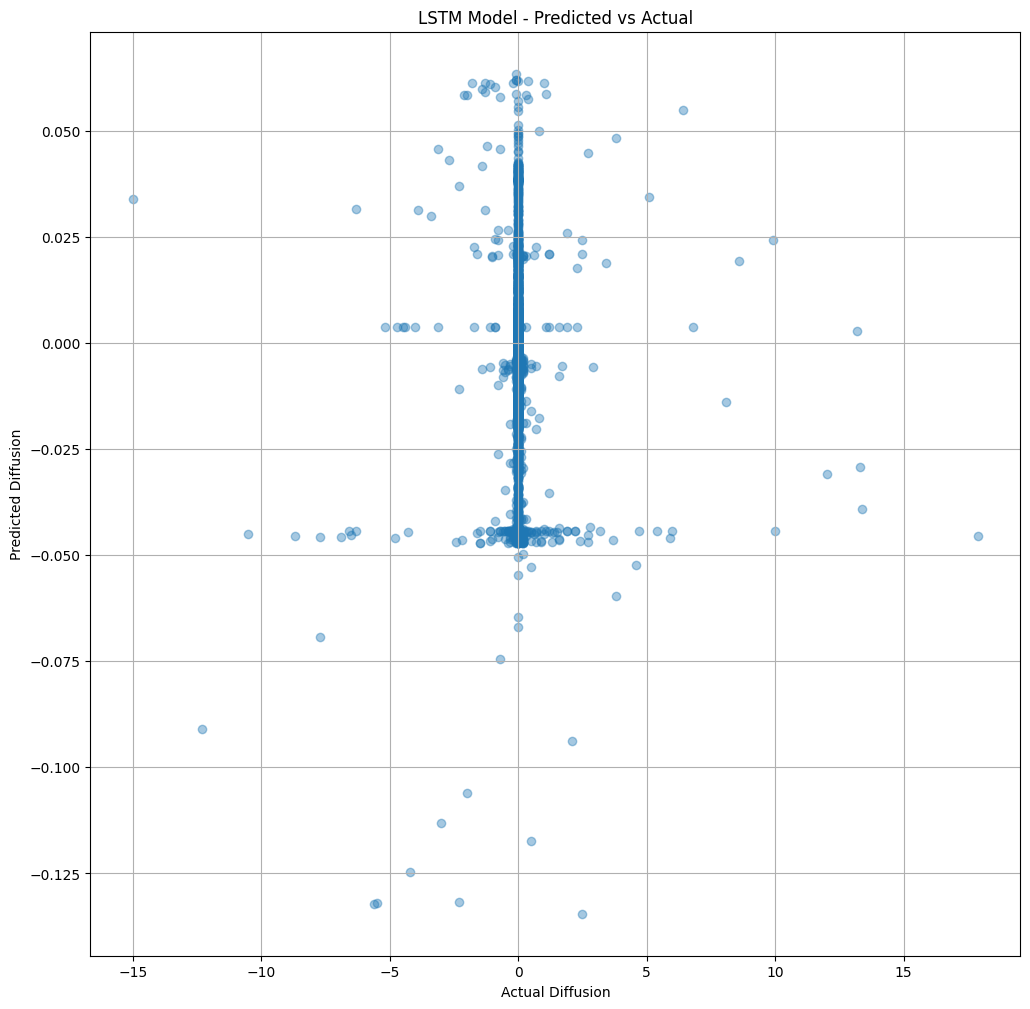

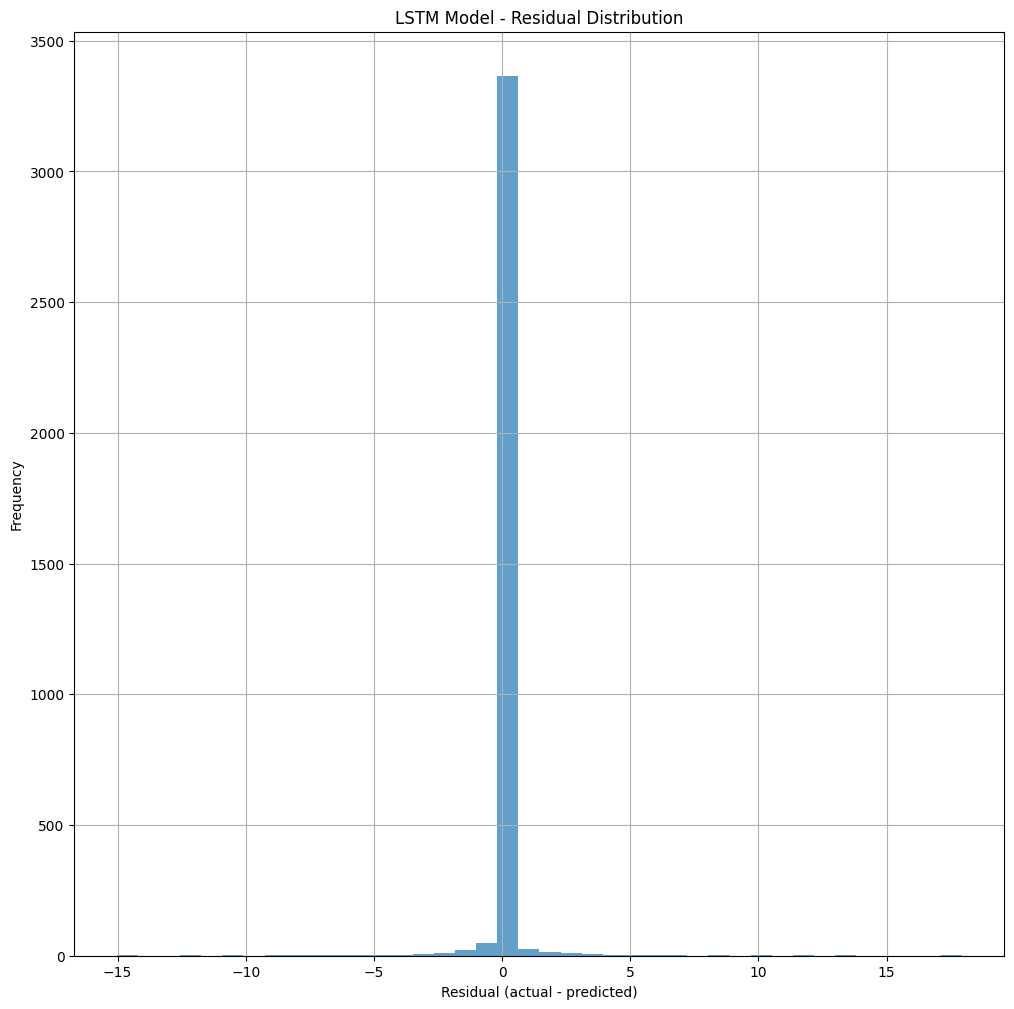

In [53]:
# Model Training and Evaluation
lstm = DiffusionLSTM(input_dim)

history_lstm = train_with_history(
    lstm, X_train, y_train, X_val, y_val, batch_size = 10, epochs=10
)

plot_training(history_lstm, "LSTM Model")
plot_predictions(lstm, X_test, y_test, "LSTM Model")


## Model 2 — Temporal CNN (TCN-1D)

In [32]:
# Initializing Model
class TCN1D(nn.Module):
    def __init__(self, input_dim, hidden=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv1d(input_dim, hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(hidden * seq_len, 1)

    def forward(self, x):
        x = x.transpose(1, 2)    # (batch, features, seq_len)
        out = self.network(x)
        out = out.flatten(start_dim=1)
        return self.fc(out)

Epoch 1/10: train=100330264.0000, val=8998103.0000
Epoch 2/10: train=30962968.0000, val=15605901.0000
Epoch 3/10: train=63075180.0000, val=4913625.0000
Epoch 4/10: train=27311498.0000, val=1710713.8750
Epoch 5/10: train=8921446.0000, val=5381209.0000
Epoch 6/10: train=16827626.0000, val=6066135.5000
Epoch 7/10: train=22610698.0000, val=3321019.7500
Epoch 8/10: train=17685564.0000, val=1437471.6250
Epoch 9/10: train=11166321.0000, val=1751958.0000
Epoch 10/10: train=9015775.0000, val=2229275.2500


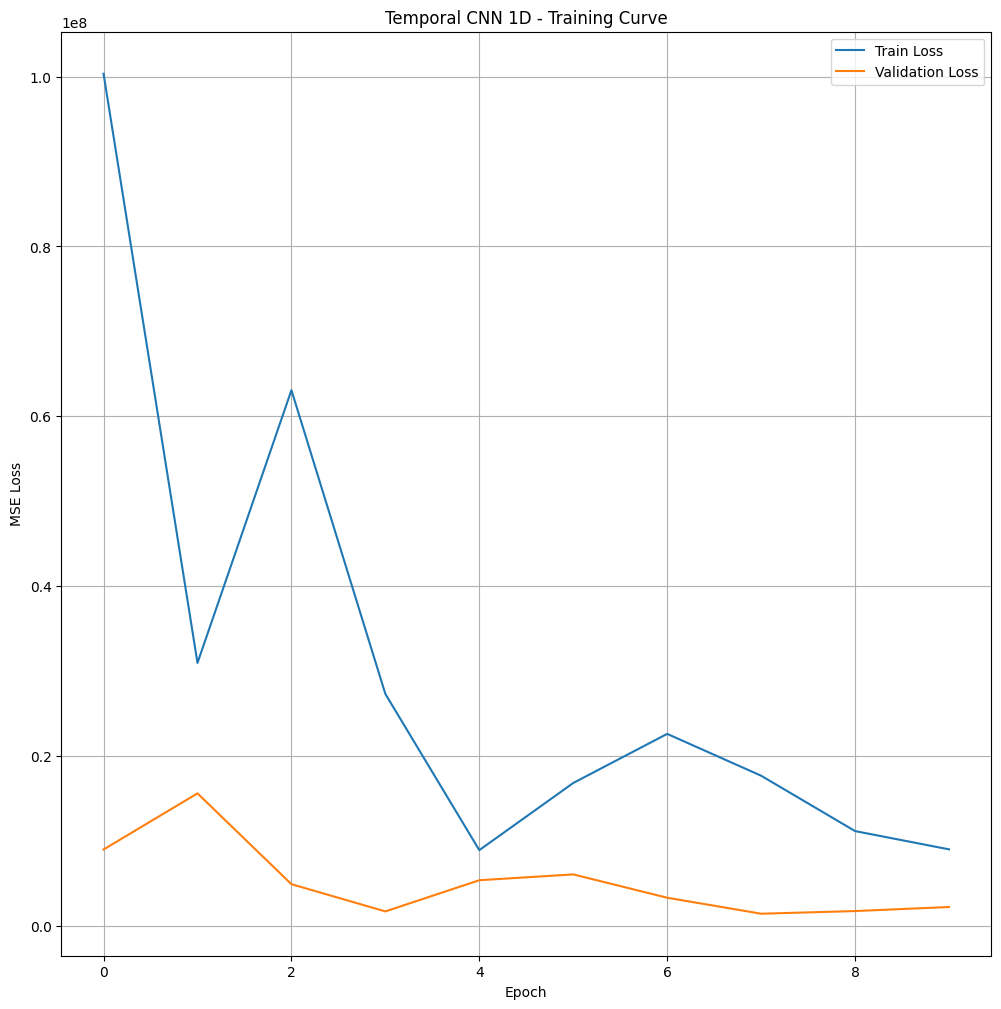

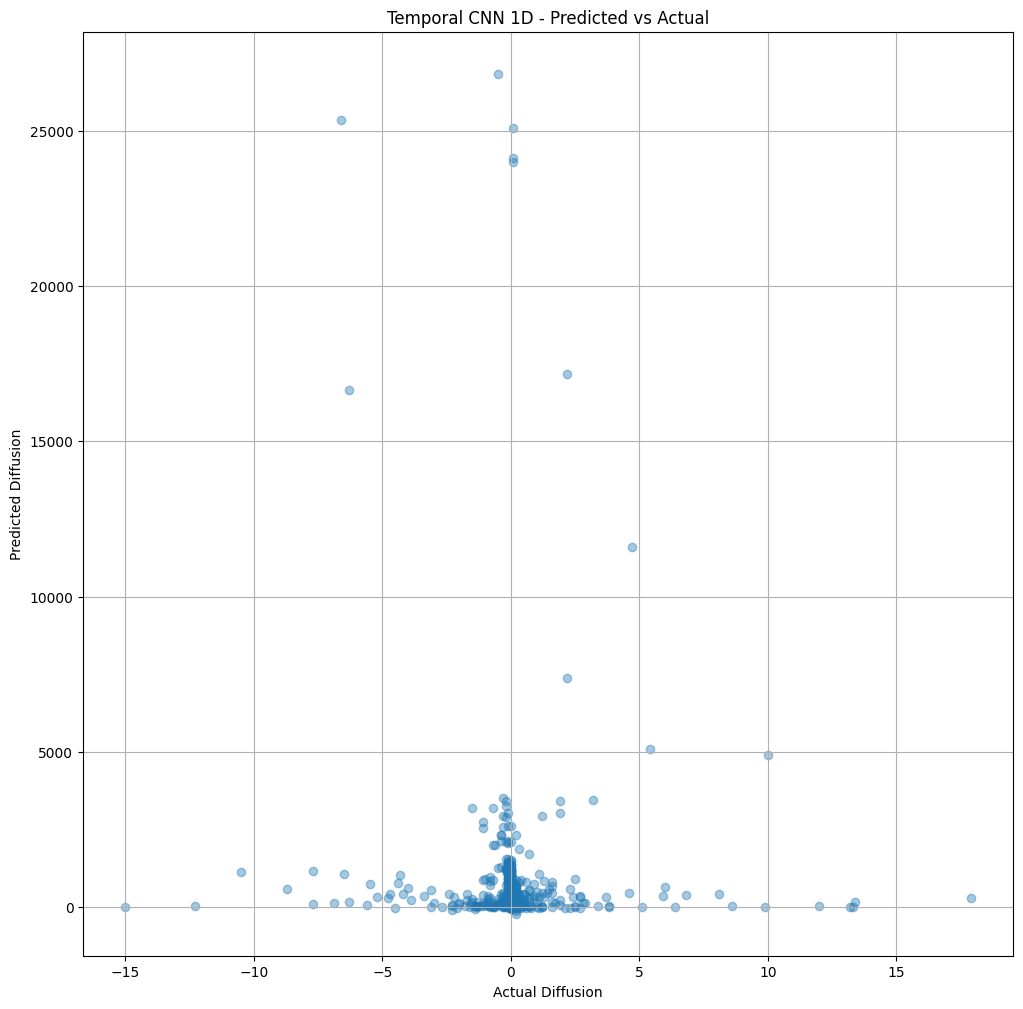

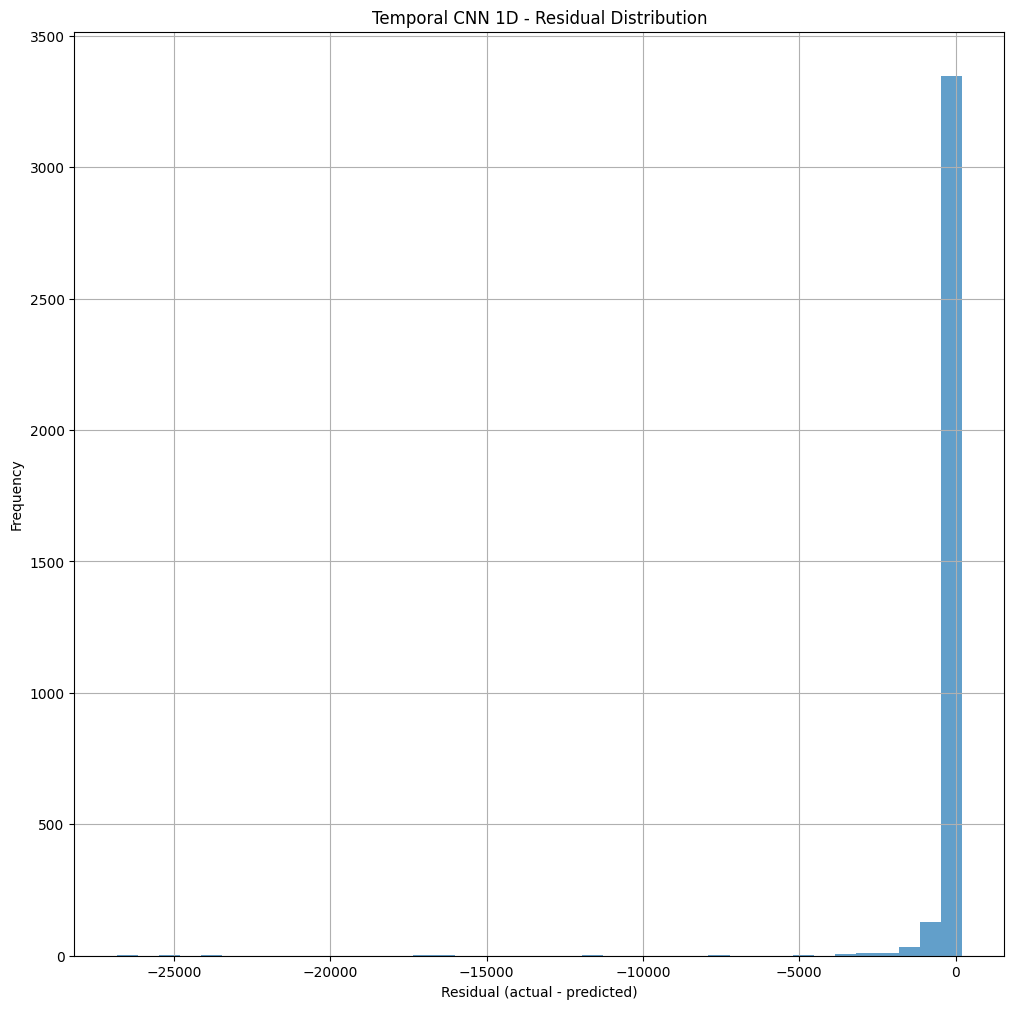

In [54]:
# Model Training and Evaluation
tcn1d = TCN1D(input_dim)

history_tcn1d = train_with_history(
    tcn1d, X_train, y_train, X_val, y_val, batch_size = 10, epochs=10
)

plot_training(history_tcn1d, "Temporal CNN 1D")
plot_predictions(tcn1d, X_test, y_test, "Temporal CNN 1D")

## Model 2 — Temporal CNN (TCN-2D)

In [34]:
# Initializing Model
class TCN2D(nn.Module):
    def __init__(self, input_dim, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, hidden, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=(3,3), padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(hidden * seq_len * input_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)   # add channel dimension
        out = self.net(x)
        out = out.flatten(start_dim=1)
        return self.fc(out)

Epoch 1/10: train=187081712.0000, val=28627208.0000
Epoch 2/10: train=109791656.0000, val=31305994.0000
Epoch 3/10: train=115962920.0000, val=6495405.5000
Epoch 4/10: train=21426440.0000, val=1753738.0000
Epoch 5/10: train=8343415.5000, val=8440506.0000
Epoch 6/10: train=36673096.0000, val=10212260.0000
Epoch 7/10: train=42332756.0000, val=5796025.5000
Epoch 8/10: train=23336734.0000, val=1231600.7500
Epoch 9/10: train=4835139.5000, val=191977.9219
Epoch 10/10: train=1103825.6250, val=1830670.7500


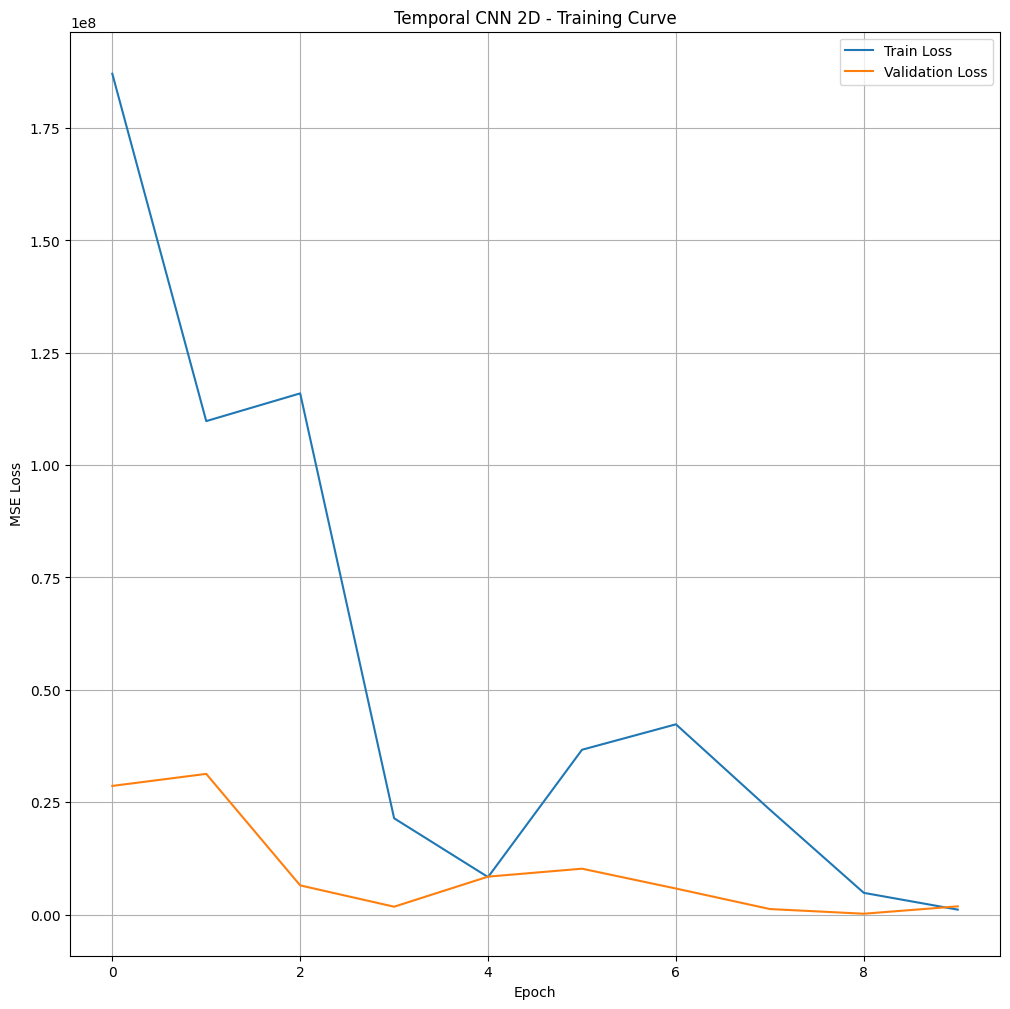

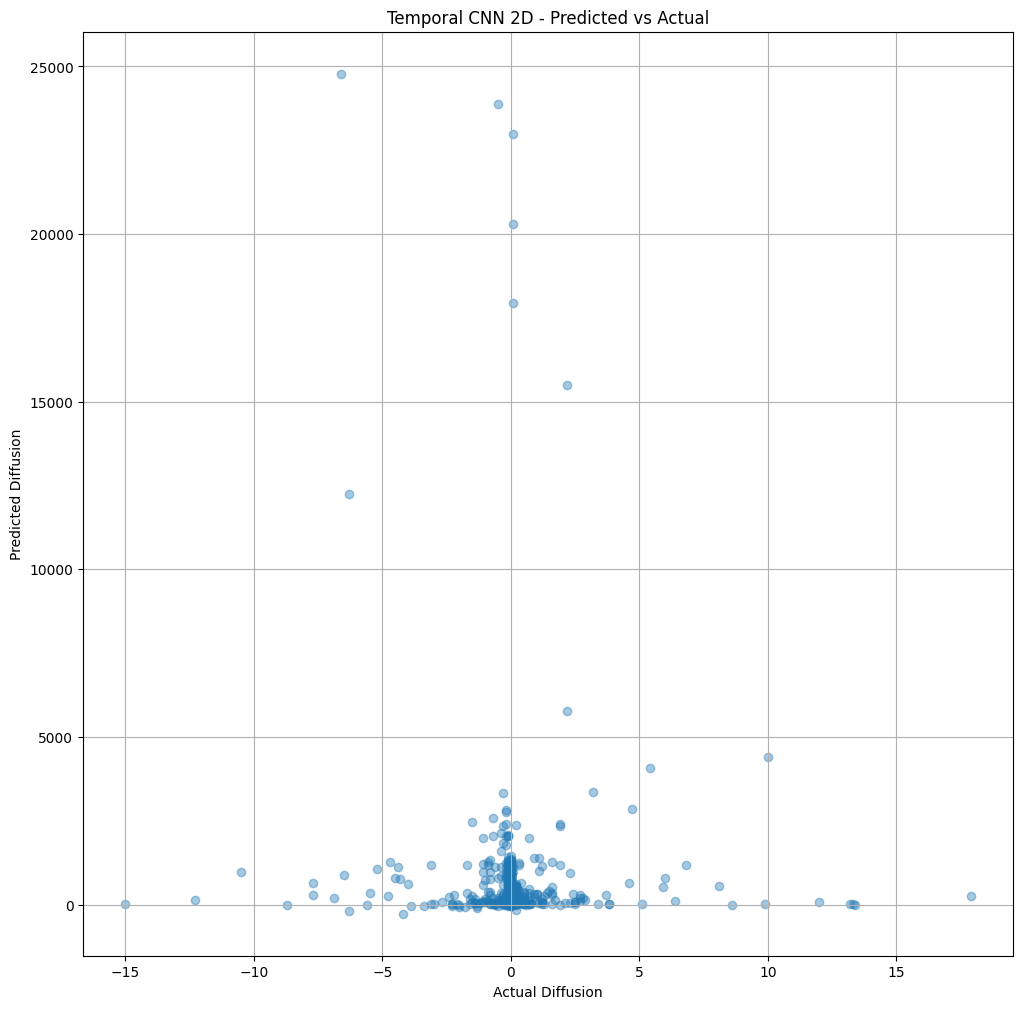

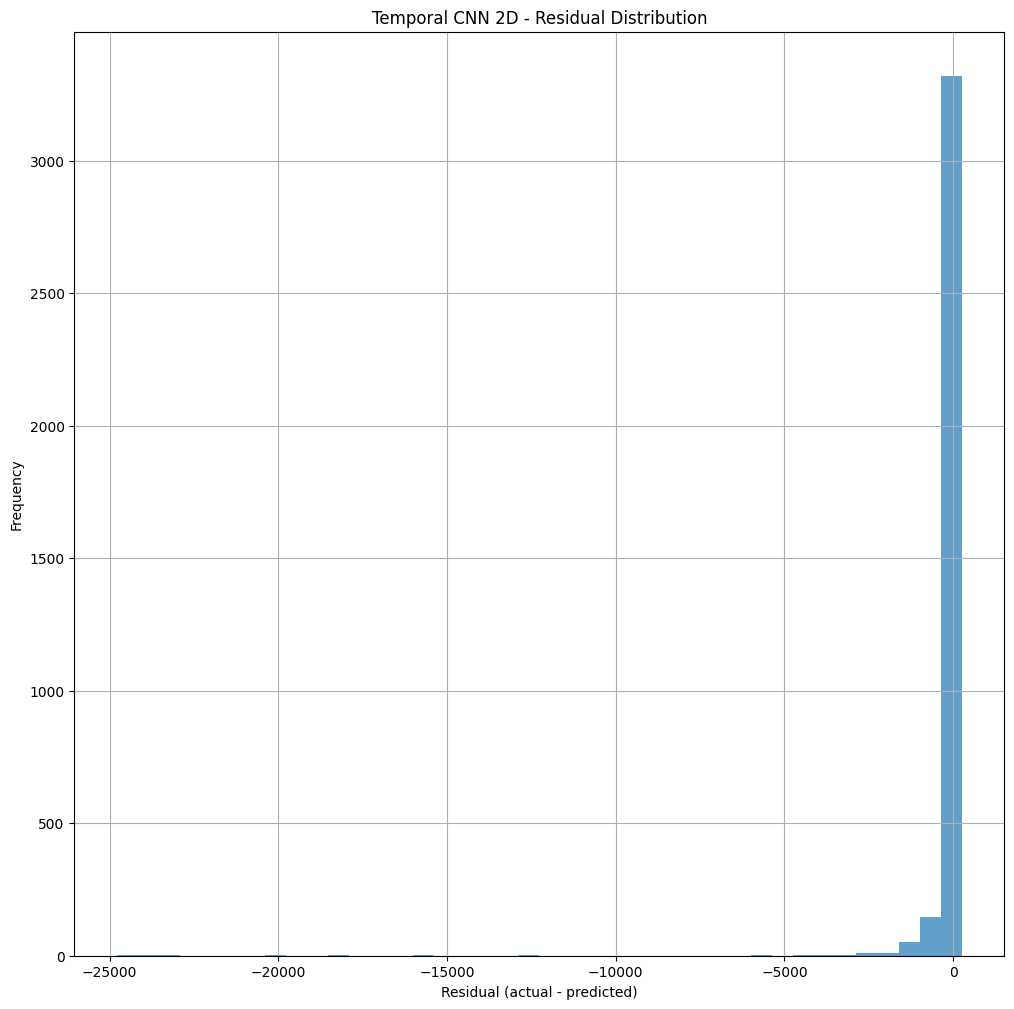

In [55]:
# Model Training and Evaluation
tcn2d = TCN2D(input_dim)

history_tcn2d = train_with_history(
    tcn2d, X_train, y_train, X_val, y_val, batch_size = 10, epochs=10
)

plot_training(history_tcn2d, "Temporal CNN 2D")
plot_predictions(tcn2d, X_test, y_test, "Temporal CNN 2D")

## Test Set Perfromance Evaluation

### Intialization of Functions

In [37]:
# Getting Predictions
def get_predictions(model, X_test):
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        preds = model(X_test_t).numpy().flatten()
    return preds

In [38]:
# Getting RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [39]:
# Getting MAE
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [41]:
# Directional Accuracy
def directional_accuracy(y_true, y_pred):
    direction_true = np.sign(y_true)
    direction_pred = np.sign(y_pred)

    correct = (direction_true == direction_pred).sum()
    total = len(y_true)

    return correct / total

In [60]:
# Evaluation Function
def evaluate_model(model, X_test, y_test, name="Model"):

    y_pred = get_predictions(model, X_test)
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()

    results = {
        "RMSE": rmse(y_test, y_pred),
        "MAE": mae(y_test, y_pred),
        "Directional_Accuracy": directional_accuracy(y_test, y_pred)
    }

    print(f"\n{name} Evaluation Metrics:")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

    return results


### Evaluation

In [61]:
#LSTM
evaluate_model(lstm, X_test, y_test, "LSTM")


LSTM Evaluation Metrics:
RMSE: 0.9328
MAE: 0.1585
Directional_Accuracy: 0.0564


{'RMSE': np.float64(0.9328250832564957),
 'MAE': 0.15849491650025493,
 'Directional_Accuracy': np.float64(0.05636978579481398)}

In [62]:
# TCNN 1D
evaluate_model(tcn1d, X_test, y_test, "Temporal CNN 1D")


Temporal CNN 1D Evaluation Metrics:
RMSE: 1105.2555
MAE: 153.2000
Directional_Accuracy: 0.0496


{'RMSE': np.float64(1105.255502141429),
 'MAE': 153.19998388256283,
 'Directional_Accuracy': np.float64(0.0496054114994363)}

In [63]:
#TCNN 2D
evaluate_model(tcn2d, X_test, y_test, "Temporal CNN 2D")


Temporal CNN 2D Evaluation Metrics:
RMSE: 947.5465
MAE: 135.5577
Directional_Accuracy: 0.0555


{'RMSE': np.float64(947.5465168750229),
 'MAE': 135.55771819632648,
 'Directional_Accuracy': np.float64(0.05552423900789177)}